<a href="https://www.kaggle.com/code/nikhilkhetan/setting-up-a-validation-set?scriptVersionId=98248743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jun-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2022/data.csv


## In this competition, we have been given only one dataset with some missing values and our goal is to predict for those missing values. 

## The aim of this notebook is to show how to create training and validation sets from the entire data and use that to improve the model's performance.

## Some functions to generate plots have been taken from [this](https://www.kaggle.com/code/robikscube/handling-with-missing-data-youtube-stream) notebook.

## Update

#### 1. The actual % of missing values per column is 1.8% and not 18%. This has been rectified.
#### 2. A Cross validation loop has been included in place of simple train_test_split.
#### 3. The metric has been changed to RMSE instead of MSE.

In [2]:
import matplotlib.pylab as plt
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

import seaborn as sns

In [3]:
train = pd.read_csv("../input/tabular-playground-series-jun-2022/data.csv")
ss = pd.read_csv("../input/tabular-playground-series-jun-2022/sample_submission.csv")

In [4]:
train.shape

(1000000, 81)

## Function to plot % of missing values

In [5]:
def show_perc_values_missing(df):
    ncounts = pd.DataFrame([df.isna().mean()]).T
    ncounts = ncounts.rename(columns={0: "train_missing"})

    ncounts.query("train_missing > 0").plot(
        kind="barh", figsize=(8, 15), title="% of Values Missing"
    )
    plt.show()

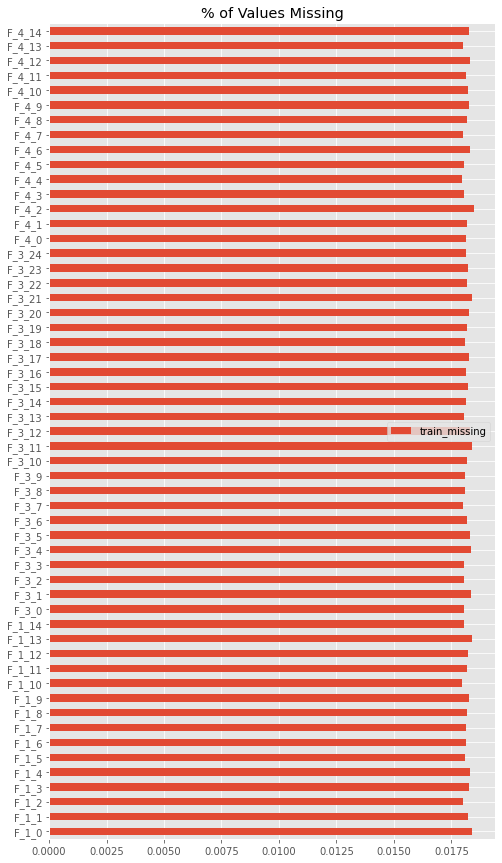

In [6]:
show_perc_values_missing(train)

## ~1.8% of values is missing in each column

In [7]:
#List of all columns with missing values
nacols = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6',
       'F_1_7', 'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13',
       'F_1_14', 'F_3_0', 'F_3_1', 'F_3_2',
       'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10',
       'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 'F_3_15', 'F_3_16', 'F_3_17',
       'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24',
       'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7',
       'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']

In [8]:
#Generate a feature to track the number of missing values in a row.
train["n_missing"] = train[nacols].isna().sum(axis=1)

<AxesSubplot:title={'center':'Number of Missing Values per Sample'}>

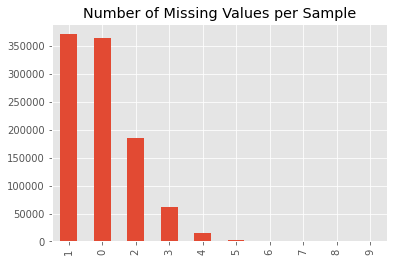

In [9]:
train["n_missing"].value_counts().plot(
    kind="bar", title="Number of Missing Values per Sample"
)

In [10]:
rows_with_no_missing = train.query("n_missing == 0")
rows_with_no_missing

,row_id,F_1_0,F_1_1,F_1_2,F_1_3,F_1_4,F_1_5,F_1_6,F_1_7,F_1_8,...,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14,n_missing
6,6,0.533210,1.662285,0.601138,-0.662212,0.033856,-0.056208,-1.781594,0.326768,1.583396,...,4.226621,-1.136903,0.171289,0.703419,-0.779643,4.721938,1.835678,-6.408681,0.538917,0
8,8,-0.334935,-0.801940,-0.754364,-0.369206,0.781484,1.024585,-0.394121,-0.588350,0.092130,...,2.535868,-0.617469,0.107925,-1.063796,-0.128948,3.340392,-0.966351,0.899595,-0.037505,0
9,9,0.144170,-0.580150,-0.896780,-0.550178,1.231237,-0.474318,-1.230894,0.474766,0.367473,...,1.543487,0.823975,0.036584,-1.029416,0.637053,0.681586,1.674981,-1.291278,0.553247,0
15,15,0.386307,-0.164298,-1.208667,0.768579,-2.200503,-1.498463,0.120240,0.865945,1.371115,...,-0.854097,-1.151623,0.480169,-0.112417,0.154438,3.835651,-4.028104,-2.736279,0.190985,0
16,16,0.641497,0.714770,0.958424,0.765871,-1.713403,-1.081687,0.943967,0.329246,2.207749,...,0.674887,1.679765,0.130678,0.421721,0.585881,-0.348452,-0.782981,3.389371,-0.487223,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999989,999989,0.170037,-0.211452,-2.404505,-0.507762,0.407780,0.747040,1.238974,0.507713,-1.320281,...,-0.949488,-4.463064,-0.235551,-0.334151,-1.630128,-9.629801,4.005267,-3.800358,-1.961221,0
999995,999995,-0.823740,0.285673,0.343307,-0.436747,1.700549,-1.069432,0.819698,-0.168457,-0.429074,...,-0.301352,5.339675,-0.991529,1.279494,-0.841051,-2.276500,1.762961,5.324553,-0.228733,0
999996,999996,-0.769106,-0.387363,-1.227469,0.601183,0.351161,0.219475,-0.530277,0.853452,0.608646,...,-1.299360,-0.071713,-0.162173,0.072501,-0.614687,-1.265524,0.190385,-0.344112,-0.346807,0
999998,999998,-1.709886,-0.813785,-1.866536,-0.179420,2.231478,1.460122,-0.220585,-0.118496,-0.140064,...,-5.127360,-3.903728,-1.597023,0.893159,0.379434,0.846266,-1.085554,3.122423,0.004831,0


## ~36% of the rows have no missing values. 

## We can use these 36% of the rows to create training and validation sets. But we have to keep certain things in mind to ensure that the train data we create resembles the original dataset as closely as possible. This is done by the below steps.

* Introduce missing values **"randomly"** in the 36% of the rows with no missing data.
* Make sure to keep "F_2_*" columns as non-missing.
* Ensure around 1.8% of the data is misssing in each column.

## Since we know the ground truth values for these 36% of the rows, we can use the training and validation sets thus created to compare models and improve performance.

In [11]:
rows_with_no_missing.drop(['row_id', 'n_missing'], axis=1, inplace=True)

## Create a copy of the dataframe containing rows with no missing values and then randomly introduce ~1.8% of missing values in each column

In [12]:
sub_train_ground_truth = rows_with_no_missing.copy()

In [13]:
for col in nacols:
    vals_to_nan = rows_with_no_missing[col].sample(frac=0.018).index
    rows_with_no_missing.loc[vals_to_nan, col] = np.NaN

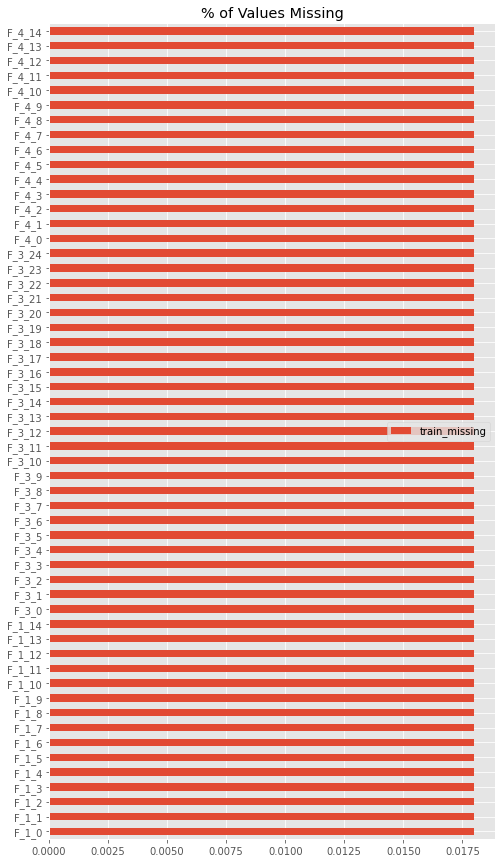

In [14]:
# Check % of missing values in newly created dataframe
show_perc_values_missing(rows_with_no_missing)

## Exactly 1.8% of the values is now missing in our data. Now we will split it into training and validation sets, try an Imputer on both sets and check its performance.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

## Simple Imputer

In [16]:
from sklearn.impute import SimpleImputer
imptr = SimpleImputer(strategy="mean", add_indicator=False)

In [17]:
kf = KFold(n_splits=5)

mse_train=[]
mse_valid=[]

for i, (train_idx, valid_idx) in enumerate(kf.split(rows_with_no_missing)):
    print("CV fold:" + str(i+1))
    
    train_imputed = imptr.fit_transform(rows_with_no_missing.iloc[train_idx])
    train_imputed = pd.DataFrame(train_imputed, columns=rows_with_no_missing.columns)
    
    valid_imputed = imptr.transform(rows_with_no_missing.iloc[valid_idx])
    valid_imputed = pd.DataFrame(valid_imputed, columns=rows_with_no_missing.columns)
    
    y_train = sub_train_ground_truth.iloc[train_idx]
    y_valid = sub_train_ground_truth.iloc[valid_idx]
    
    mse_train.append(np.sqrt(mean_squared_error(y_train, train_imputed)))
    mse_valid.append(np.sqrt(mean_squared_error(y_valid, valid_imputed)))
    
    print("Training error:" + str(np.sqrt(mean_squared_error(y_train, train_imputed))))
    print("Validation error:" + str(np.sqrt(mean_squared_error(y_valid, valid_imputed))))

CV fold:1
Training error:0.15797571781440684
Validation error:0.15741600033362646
CV fold:2
Training error:0.15764280591133392
Validation error:0.1587490009711734
CV fold:3
Training error:0.15812952427726162
Validation error:0.15680153473374464
CV fold:4
Training error:0.15778576981306994
Validation error:0.15818531689859452
CV fold:5
Training error:0.1577897317767187
Validation error:0.15816543464345195


In [18]:
print("The average training error is: " + str(sum(mse_train)/len(mse_train)))
print("The average CV error is: " + str(sum(mse_valid)/len(mse_valid)))

The average training error is: 0.15786470991855822
The average CV error is: 0.1578634575161182


## LGBM Imputer

In [19]:
# !rm -r kuma_utils
!git clone https://github.com/analokmaus/kuma_utils.git

Cloning into 'kuma_utils'...
remote: Enumerating objects: 895, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 895 (delta 93), reused 90 (delta 90), pack-reused 795
Receiving objects: 100% (895/895), 669.35 KiB | 10.14 MiB/s, done.
Resolving deltas: 100% (581/581), done.


In [20]:
import sys
sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

In [21]:
lgbm_imtr = LGBMImputer(n_iter=100, verbose=True)

mse_train_lgbm=[]
mse_valid_lgbm=[]

for i, (train_idx, valid_idx) in enumerate(kf.split(rows_with_no_missing)):
    print("CV fold:" + str(i+1))
    
    train_imputed = lgbm_imtr.fit_transform(rows_with_no_missing.iloc[train_idx])
    train_imputed = pd.DataFrame(train_imputed, columns=rows_with_no_missing.columns)
    
    valid_imputed = lgbm_imtr.transform(rows_with_no_missing.iloc[valid_idx])
    valid_imputed = pd.DataFrame(valid_imputed, columns=rows_with_no_missing.columns)
    
    y_train = sub_train_ground_truth.iloc[train_idx]
    y_valid = sub_train_ground_truth.iloc[valid_idx]
    
    mse_train_lgbm.append(np.sqrt(mean_squared_error(y_train, train_imputed)))
    mse_valid_lgbm.append(np.sqrt(mean_squared_error(y_valid, valid_imputed)))
    
    print("Training error:" + str(np.sqrt(mean_squared_error(y_train, train_imputed))))
    print("Validation error:" + str(np.sqrt(mean_squared_error(y_valid, valid_imputed))))

CV fold:1


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Training error:0.11611796973144162
Validation error:0.1163375105632003
CV fold:2


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Training error:0.11611219449197611
Validation error:0.1161004367852917
CV fold:3


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Training error:0.11607156871213854
Validation error:0.1165603250147397
CV fold:4


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Training error:0.11630559949218779
Validation error:0.1156242642743395
CV fold:5


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Training error:0.1161591520134812
Validation error:0.11609311342155983


In [22]:
print("The average training error is: " + str(sum(mse_train_lgbm)/len(mse_train_lgbm)))
print("The average CV error is: " + str(sum(mse_valid_lgbm)/len(mse_valid_lgbm)))

The average training error is: 0.11615329688824505
The average CV error is: 0.11614313001182619


In [23]:
data = [['Simple_Imputer','0.1578772878904608', '0.15787718194045347'], ['LGBM_Imputer', '0.11630687954281457', '0.11633002301138315' ]]
df = pd.DataFrame(data, columns=['Model','Training_Error', 'Cross Validation_Error'])
 
df

,Model,Training_Error,Cross Validation_Error
0,Simple_Imputer,0.1578772878904608,0.15787718194045347
1,LGBM_Imputer,0.11630687954281457,0.11633002301138315


## Will add and compare more models that have been used in this competition so far.

# Thanks for reading!!